In ensemble model (NN+Ridge) we saw that the real values are way more volatile than the prediction so decided to describe volitily with GARCH model (which is popular in finance) and combine it with NN.

So, firstly, we need to predict volatility of responder_6 (or predict volatility of all responders/features) and then we use this volatility as an aditional feature to forecast the next value with NN.

In [2]:
! pip install arch tensorflow -q
import numpy as np
import polars as pl
import pandas as pd
from arch import arch_model
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import warnings
warnings.filterwarnings('ignore')
import gc
import matplotlib.pyplot as plt

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 38.6 MB/s eta 0:00:00


In [1]:
# Configs
SEQ_LEN = 10
BATCH_SIZE = 1024
EPOCHS = 20
GARCH_P = 1
GARCH_Q = 1
CHUNK_SIZE = 5

train_path = "/kaggle/input/Preprocessing/training.parquet/"
valid_path = "/kaggle/input/Preprocessing/validation.parquet/"


# jane_street_real_time_market_data_forecasting_path = kagglehub.competition_download('jane-street-real-time-market-data-forecasting')

'/kaggle/input/js24-preprocessing-catboost/training.parquet/'

# Garch+LSTM

In [3]:
# StandardScaler с обработкой NaN
class SafeScaler(StandardScaler):
    def transform(self, X):
        X_scaled = super().transform(X)
        return np.nan_to_num(X_scaled, nan=0.0)

def load_data_chunked(path, days=None):
    features = [f"feature_{i:02d}" for i in range(79)]
    df = (
        pl.scan_parquet(path)
        .select(features + ['responder_6', 'weight', 'date_id', 'time_id'])
    )
    if days:
        unique_dates = df.select(pl.col('date_id').unique()).collect().to_series()
        selected_dates = unique_dates.sort()[:days]
        df = df.filter(pl.col('date_id').is_in(selected_dates))
    return df.collect().to_pandas()

# GARCH
print("Fitting GARCH model...")
train_sample = load_data_chunked(
    train_path,
    days=10
)
garch_model = arch_model(
    train_sample['responder_6'],
    vol='Garch',
    p=GARCH_P,
    q=GARCH_Q,
    rescale=False
)
garch_fit = garch_model.fit(disp='off')
del train_sample
gc.collect()

def data_generator(df_path, garch_fit, seq_len, chunk_size=CHUNK_SIZE):
    features = [f"feature_{i:02d}" for i in range(79)]
    dates = pl.scan_parquet(df_path).select('date_id').unique().collect().to_series()
    
    for i in range(0, len(dates), chunk_size):
        chunk_dates = dates[i:i+chunk_size]
        df = (
            pl.scan_parquet(df_path)
            .filter(pl.col('date_id').is_in(chunk_dates))
            .collect()
            .sort(['date_id', 'time_id'])
            .to_pandas()
        )
        
        # Расчет GARCH волатильности
        omega = garch_fit.params['omega']
        alpha = garch_fit.params['alpha[1]']
        beta = garch_fit.params['beta[1]']
        
        garch_vol = np.zeros(len(df))
        garch_vol[0] = np.sqrt(omega / (1 - alpha - beta))
        
        for t in range(1, len(df)):
            garch_vol[t] = np.sqrt(
                omega + 
                alpha * df['responder_6'].iloc[t-1]**2 + 
                beta * garch_vol[t-1]**2
            )
        
        df['garch_vol'] = garch_vol
        
        # Создание последовательностей
        X, y, w = [], [], []
        for date in df['date_id'].unique():
            day_data = df[df['date_id'] == date]
            values = day_data[features + ['garch_vol']].values
            targets = day_data['responder_6'].values
            weights = day_data['weight'].values
            
            for j in range(len(day_data) - seq_len):
                X.append(values[j:j+seq_len])
                y.append(targets[j+seq_len])
                w.append(weights[j+seq_len])
        
        yield np.nan_to_num(np.array(X)), np.nan_to_num(np.array(y)), np.nan_to_num(np.array(w))
        del df, X, y, w
        gc.collect()

# Dataset
def create_safe_dataset(df_path, garch_fit, scaler, seq_len, batch_size):
    def generator():
        for X, y, w in data_generator(df_path, garch_fit, seq_len):
            X_scaled = scaler.transform(X.reshape(-1, X.shape[2])).reshape(X.shape)
            for i in range(0, len(X), batch_size):
                yield X_scaled[i:i+batch_size], y[i:i+batch_size], w[i:i+batch_size]
    
    sample_X, _, _ = next(data_generator(df_path, garch_fit, seq_len))
    
    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(None, seq_len, sample_X.shape[2]), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    ).prefetch(tf.data.AUTOTUNE)

Fitting GARCH model...


In [4]:
def lstm_model(input_shape):
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.LSTM(64, return_sequences=False, 
                   kernel_regularizer='l2', recurrent_regularizer='l2'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', kernel_regularizer='l2'),
        layers.BatchNormalization(),
        layers.Dense(1, activation='linear')
    ])
    
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.001,
        clipvalue=1.0
    )
    
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

Fitting GARCH model...
Epoch 1/20
8181/8181 - 398s - 49ms/step - loss: 1.7348 - root_mean_squared_error: 0.8064 - val_loss: 1.0738 - val_root_mean_squared_error: 0.7478
Epoch 2/20
8181/8181 - 388s - 47ms/step - loss: 1.5641 - root_mean_squared_error: 0.8038 - val_loss: 1.0689 - val_root_mean_squared_error: 0.7472
Epoch 3/20
8181/8181 - 380s - 47ms/step - loss: 1.5597 - root_mean_squared_error: 0.8037 - val_loss: 1.0603 - val_root_mean_squared_error: 0.7451
Epoch 4/20
8181/8181 - 383s - 47ms/step - loss: 1.5581 - root_mean_squared_error: 0.8037 - val_loss: 1.0775 - val_root_mean_squared_error: 0.7508
Epoch 5/20
8181/8181 - 382s - 47ms/step - loss: 1.5570 - root_mean_squared_error: 0.8038 - val_loss: 1.0823 - val_root_mean_squared_error: 0.7524
Epoch 6/20
8181/8181 - 384s - 47ms/step - loss: 1.5567 - root_mean_squared_error: 0.8039 - val_loss: 1.0675 - val_root_mean_squared_error: 0.7477
Epoch 7/20
8181/8181 - 385s - 47ms/step - loss: 1.5567 - root_mean_squared_error: 0.8040 - val_loss: 

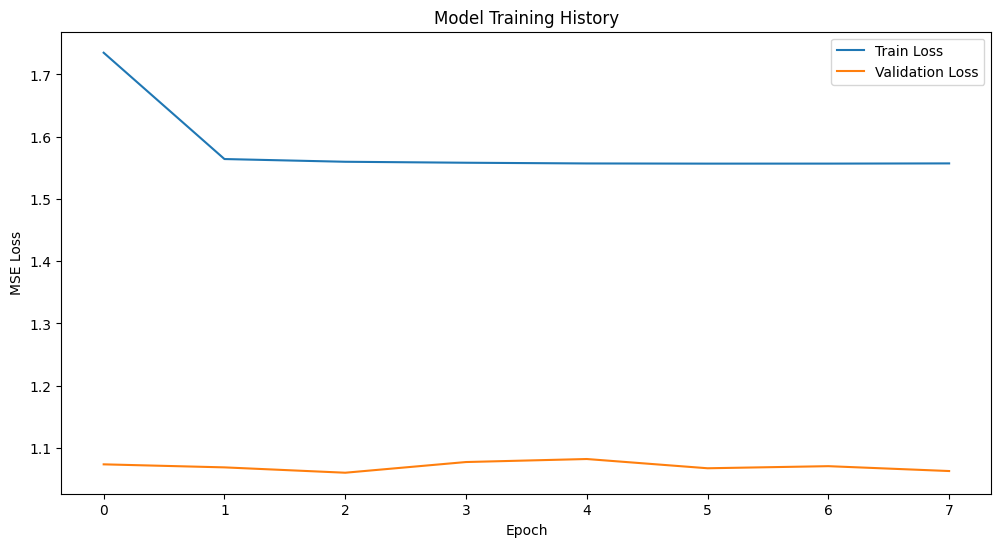

In [4]:
scaler = SafeScaler()
train_gen = data_generator(
    train_path,
    garch_fit,
    SEQ_LEN
)
X_first, _, _ = next(train_gen)
scaler.fit(X_first.reshape(-1, X_first.shape[2]))
del X_first
gc.collect()

model = lstm_model((SEQ_LEN, 80))

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    create_safe_dataset(
        train_path,
        garch_fit,
        scaler,
        SEQ_LEN,
        BATCH_SIZE
    ),
    validation_data=create_safe_dataset(
        valid_path,
        garch_fit,
        scaler,
        SEQ_LEN,
        BATCH_SIZE
    ),
    epochs=EPOCHS,
    callbacks=[early_stop],
    verbose=2
)

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# LSTM без GARCH

Total samples: 8352538, steps: 8156
Total samples: 789678, steps: 771
Epoch 1/10
8156/8156 - 187s - 23ms/step - loss: 1.7542 - root_mean_squared_error: 0.8086 - val_loss: 1.0893 - val_root_mean_squared_error: 0.7529
Epoch 2/10
8156/8156 - 172s - 21ms/step - loss: 1.5701 - root_mean_squared_error: 0.8037 - val_loss: 1.0863 - val_root_mean_squared_error: 0.7534
Epoch 3/10
8156/8156 - 163s - 20ms/step - loss: 1.5614 - root_mean_squared_error: 0.8042 - val_loss: 1.0653 - val_root_mean_squared_error: 0.7466
Epoch 4/10
8156/8156 - 159s - 20ms/step - loss: 1.5611 - root_mean_squared_error: 0.8045 - val_loss: 1.0691 - val_root_mean_squared_error: 0.7478
Epoch 5/10
8156/8156 - 164s - 20ms/step - loss: 1.5586 - root_mean_squared_error: 0.8038 - val_loss: 1.0714 - val_root_mean_squared_error: 0.7485
Epoch 6/10
8156/8156 - 162s - 20ms/step - loss: 1.5579 - root_mean_squared_error: 0.8038 - val_loss: 1.0953 - val_root_mean_squared_error: 0.7564
Epoch 7/10
8156/8156 - 163s - 20ms/step - loss: 1.5589

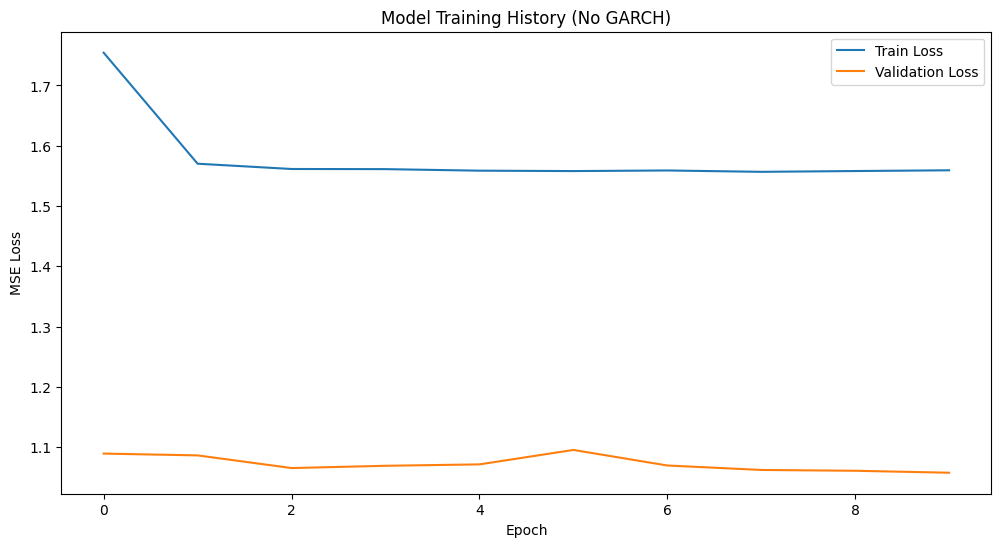


Weighted MSE: 0.519527
Weighted R²: 0.001035
Model saved successfully.


In [5]:
EPOCHS = 10
# без GARCH
def data_generator_no_garch(df_path, seq_len, chunk_size=CHUNK_SIZE):
    features = [f"feature_{i:02d}" for i in range(79)]
    dates = pl.scan_parquet(df_path).select('date_id').unique().collect().to_series()
    
    for i in range(0, len(dates), chunk_size):
        chunk_dates = dates[i:i+chunk_size]
        df = (
            pl.scan_parquet(df_path)
            .filter(pl.col('date_id').is_in(chunk_dates))
            .collect()
            .sort(['date_id', 'time_id'])
            .to_pandas()
        )
        
        df = df.fillna(df.mean())
        # df = df.dropna(subset=features + ['responder_6', 'weight'])
        

        X, y, w = [], [], []
        for date in df['date_id'].unique():
            day_data = df[df['date_id'] == date]
            if len(day_data) < seq_len:
                continue
                
            values = day_data[features].values
            targets = day_data['responder_6'].values
            weights = day_data['weight'].values
            
            for j in range(len(day_data) - seq_len):
                X.append(values[j:j+seq_len])
                y.append(targets[j+seq_len])
                w.append(weights[j+seq_len])
        
        if len(X) > 0:
            yield np.array(X), np.array(y), np.array(w)
        del df, X, y, w
        gc.collect()

def create_safe_dataset_no_garch(df_path, scaler, seq_len, batch_size):
    def generator():
        while True:  # Бесконечный цикл для повторения данных
            for X, y, w in data_generator_no_garch(df_path, seq_len):
                X_scaled = scaler.transform(X.reshape(-1, X.shape[2])).reshape(X.shape)
                for i in range(0, len(X), batch_size):
                    yield X_scaled[i:i+batch_size], y[i:i+batch_size], w[i:i+batch_size]
    
    # пример данных для определения формы
    sample_X, _, _ = next(data_generator_no_garch(df_path, seq_len))
    
    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(None, seq_len, sample_X.shape[2]), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    ).prefetch(tf.data.AUTOTUNE)


def calculate_steps(df_path, seq_len, batch_size):
    total_samples = 0
    dates = pl.scan_parquet(df_path).select('date_id').unique().collect().to_series()
    
    for date in dates:
        day_data = pl.scan_parquet(df_path).filter(pl.col('date_id') == date).collect()
        day_samples = max(0, len(day_data) - seq_len)
        total_samples += day_samples
    
    steps = max(1, total_samples // batch_size)
    print(f"Total samples: {total_samples}, steps: {steps}")
    return steps


scaler_no_garch = SafeScaler()
train_gen_no_garch = data_generator_no_garch(
    train_path,
    SEQ_LEN
)

# Получаем первый батч для фитинга scaler
X_first_no_garch, _, _ = next(train_gen_no_garch)
scaler_no_garch.fit(X_first_no_garch.reshape(-1, X_first_no_garch.shape[2]))
del X_first_no_garch
gc.collect()

# Создание модели
model_no_garch = lstm_model((SEQ_LEN, 79))

# Callbacks
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Рассчитываем количество шагов
train_steps = calculate_steps(
    train_path,
    SEQ_LEN,
    BATCH_SIZE
)
val_steps = calculate_steps(
    valid_path,
    SEQ_LEN,
    BATCH_SIZE
)

history_no_garch = model_no_garch.fit(
    create_safe_dataset_no_garch(
        train_path,
        scaler_no_garch,
        SEQ_LEN,
        BATCH_SIZE
    ),
    steps_per_epoch=train_steps,
    validation_data=create_safe_dataset_no_garch(
        valid_path,
        scaler_no_garch,
        SEQ_LEN,
        BATCH_SIZE
    ),
    validation_steps=val_steps,
    epochs=EPOCHS,
    callbacks=[early_stop],
    verbose=2
)


plt.figure(figsize=(12, 6))
plt.plot(history_no_garch.history['loss'], label='Train Loss')
plt.plot(history_no_garch.history['val_loss'], label='Validation Loss')
plt.title('Model Training History (No GARCH)')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


val_dataset = create_safe_dataset_no_garch(
    valid_path,
    scaler_no_garch,
    SEQ_LEN,
    BATCH_SIZE
)


y_true, y_pred, weights = [], [], []
for i, (X_batch, y_batch, w_batch) in enumerate(val_dataset):
    if i >= val_steps:  # Ограничиваем кол-вом валидационных шагов
        break
    y_true.extend(y_batch.numpy())
    y_pred.extend(model_no_garch.predict(X_batch, verbose=0).flatten())
    weights.extend(w_batch.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
weights = np.array(weights)


weighted_mse = np.sum(weights * (y_true - y_pred)**2) / np.sum(weights)
print(f"\nWeighted MSE: {weighted_mse:.6f}")

y_mean = np.average(y_true, weights=weights)
total = np.sum(weights * (y_true - y_mean)**2)
residual = np.sum(weights * (y_true - y_pred)**2)
weighted_r2 = 1 - (residual / (total + 1e-10))
print(f"Weighted R²: {weighted_r2:.6f}")

# Сохранение модели
model_no_garch.save('lstm_model_no_garch.h5')
print("Model saved successfully.")

| Метрика	         | LSTM	       | LSTM+Garch |
------------------------------------------------
| Val Loss (MSE)	 | 1.0576	   | 1.0603     |
------------------------------------------------
| Val RMSE	         | 0.7442	   | 0.7451     |
------------------------------------------------

Добавление Garch ухудшает предсказания